# State Estimation in the Budyko-Sellers energy balance model: Exploring the role of controls

This notebook runs the Budyko-Sellers 1-D energy balance model and uses its gradient to reduce the cost function J, which represents the mismatch between zonal mean temperature from NCEP and the model. It uses algorithmic differentiation in JAX.

We explore how the state estimation changes when we modify the number of controls and the uncertainties associated to them. 

* We will solve for 1 contol (albedo) and 2 controls (albedo and emissivity).
* Explore how non-dimensionalizing the inital controls helps the assimilation and provides final control values that agree better with physics and expected values.

**References**:

<font color='blue'>__[Notes on the Budyko-Sellers Model](https://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture14%20--%20Diffusive%20energy%20balance%20model.html)__</font>by Brian E. J. Rose (University at Albany)

Shreyas Gaikwad and Ian Fenty provided the Fortran code which was adapted for this notebook.

In [1]:
!pip install jax jaxlib

  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.6.1-py3-none-any.whl (2.4 MB)
Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl (89.1 MB)
Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)


In [2]:
import numpy as np
import sys
from functools import partial
import netCDF4 as nc
import matplotlib.pyplot as plt

# Jax specific imports
import jax.numpy as jnp
from jax import grad, lax,jit
from functools import partial

### Set up the model grid and read in NCEP temperature data

We will build a grid that spans from -90 to 90 degrees latitude with N=100 grid points.

Then we read in zonal mean NCEP surface temperature data from the NCEP reanalysis which will be our target. We will add some noise to that temperature vector and use it as our initial guess for the model (think of this as the output from the free running forward model).

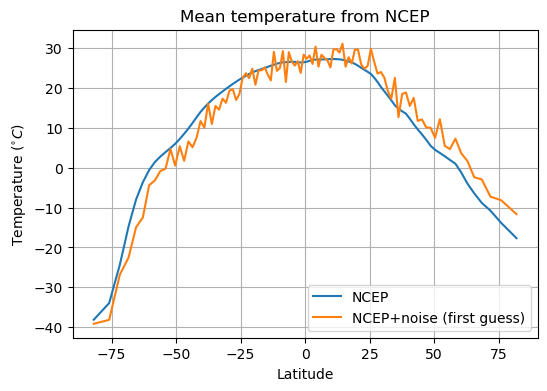

In [3]:
# Let's set up our grid
N = 100 # number of grid points
XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

## Import NCEP temperature, get zonal mean and extrapolate to grid size
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])

# Initial guess 
Ts_with_noise = Ts_annual_interp + np.random.randn(N)*2 + 5*X

fig, ax = plt.subplots(1,1, sharex=True, figsize=(6,4))
ax.set_title('Mean temperature from NCEP')
ax.plot(LAT, Ts_annual_interp, label='NCEP')
ax.plot(LAT, Ts_with_noise, label='NCEP+noise (first guess)')
ax.set_ylabel(r'Temperature ($^{\circ}C)$')
ax.set_xlabel('Latitude')
ax.grid()
ax.legend()

## One control: albedo

Let's optimize our state estimation using albedo as a control. We will provide a second Legandre polynomial as a first guess for the albedo. Through the optimization process we will get the albedo conditions necessary to obtain the state estimate (temperature).

The initial guess the "2nd Legendre polynomial" is defined as
$$P_2(x)=\frac{1}{2}(3x^2−1)$$
where $x=sin{\theta}$.

This is just one of many useful functions to describe smooth equator-to-pole changes suggested in <font color='blue'>__[Brian Rose's Budyko-Sellers notes](https://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture14%20--%20Diffusive%20energy%20balance%20model.html)__</font>.

In [12]:
def budyko_sellers_jax_1c(XXS):
    '''Budyko-Sellers forward model with albedo as control'''
    MAX_ITER = 1000  # Reduce if needed for speed
    
    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(Ts_annual_interp)

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6
    alpha0 = 0.354
    alpha2 = 0.25

    # Grid
    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    # Solar insolation
    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 

    # Initial temperature (the NCEP profile with noise)
    T_init = jnp.array(Ts_with_noise)+273.0
    
    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    
    def step(T, _):
        # Second Legandre polynomial
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) + 1*XXS

        FIN = SX * (1.0 - ALPHA)
        FOUT = EPSILON * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) + 1*XXS
      
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))/N
    return J,T_final,ALPHA

def cost_fxn_1c(XXS):
    J,_,_ = budyko_sellers_jax_1c(XXS)
    return J

### Calculate adjoint gradient

In [13]:
grad_J = grad(cost_fxn_1c)
XXS_1c = jnp.zeros(N)
dJ_dXXS_1c = grad_J(XXS_1c) 

### Minimize cost function using steepest descent

In [14]:
## gradient descent
XXS_1c = jnp.zeros(N) # Set up controls vector - size N because we have 1 value of albedo for every latitude.
ETA = 1              # Size of step to take
max_iter = 400        # maximum number of iterations to go through steepest descent
J1c = 900             # Some value to initialize the cost function
i = 0
thresh = 0.3         # Threshold value for cost function
while((J1c > thresh) & (i < max_iter)):
    J1c, T1, alpha1 = budyko_sellers_jax_1c(XXS_1c)
    g = grad_J(XXS_1c)
    print(f'Cost function at step {i}: {J1c}')
    XXS_1c = XXS_1c - ETA*g
    i = i+1

Cost function at step 0: 0.5435472130775452
Cost function at step 1: 0.4537597894668579
Cost function at step 2: 0.3968231678009033
Cost function at step 3: 0.36379745602607727
Cost function at step 4: 0.34252721071243286
Cost function at step 5: 0.3258722722530365
Cost function at step 6: 0.31118595600128174
Cost function at step 7: 0.2976855933666229


### Let's plot 

In blue we see the estimate of temperature. It fits well with the target (red dashed) except near the southern polar region probably because we have low resolution there. The albedo recovered from the estimate is shown below.

Text(0.5, 0, 'Latitude')

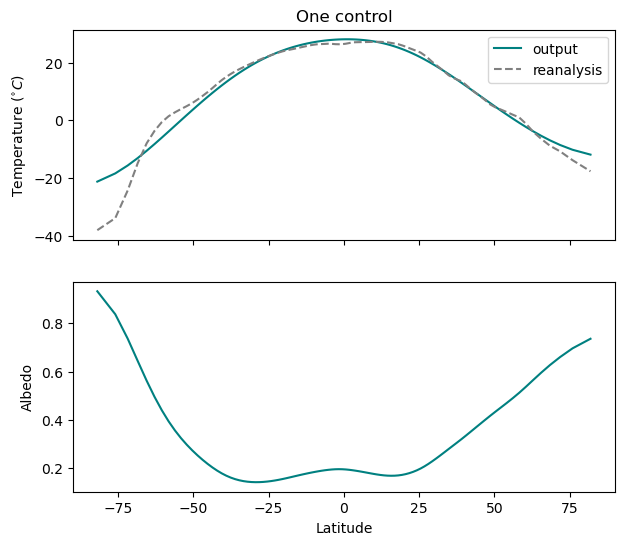

In [29]:
fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(7,6))
ax.set_title('One control')
ax.plot(LAT, T1-273, color='teal')
ax.plot(LAT,jnp.array(Ts_annual_interp),'--', color='0.5')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(LAT, alpha1, color='teal')
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Latitude')

## Two controls: albedo and emissivity

Now we will add emissivity as a control. Our initial guess will be a constant value `epsilon=0.63` and albedo will be the same as before.

In [16]:
def budyko_sellers_jax_2c(XXS):
    MAX_ITER = 1000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(Ts_annual_interp)

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 

    # Initial temperature
    T_init = jnp.array(Ts_with_noise)+273.0
    
    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25

    def step(T, _):
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)+1*XXS[:N]
        emiss = EPSILON + 1*XXS[N:]

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    
    ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)+1*XXS[:N]
    emiss = EPSILON + 1*XXS[N:]
    
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))/N
    return J,T_final,ALPHA,emiss

def cost_fxn_2c(XXS):
    J,_,_,_ = budyko_sellers_jax_2c(XXS)
    return J

In [17]:
# Calculate adjoint gradient
grad_J = grad(cost_fxn_2c)
XXS = jnp.zeros(2*N)       # Now this is 2*N because we have 2 controls.
dJ_dXXS = grad_J(XXS) 

In [18]:
## Do gradient descent
XXS = jnp.zeros(2*N)
eta = 1
max_iter = 400
J = 1000
i = 0
while((J > 0.3) & (i < max_iter)):
    J,T2,alpha2,emiss2 = budyko_sellers_jax_2c(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - eta*g
    i = i+1

Cost function at step 0: 0.5435472130775452
Cost function at step 1: 0.37607699632644653
Cost function at step 2: 0.32908669114112854
Cost function at step 3: 0.2951509356498718


Text(0.5, 0, 'Latitude')

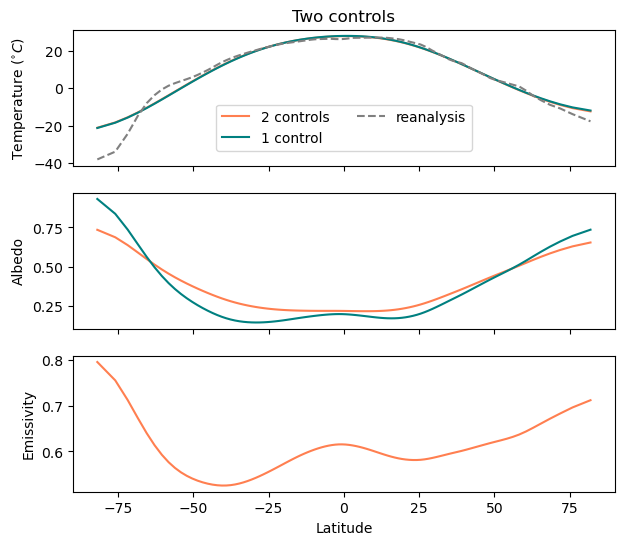

In [57]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two controls')
ax.plot(LAT, T2-273, label='2 controls', color='coral')
ax.plot(LAT, T1-273, label='1 control',  color='teal')
ax.plot(LAT,jnp.array(Ts_annual_interp),'--', label='reanalysis', color='0.5')
ax.legend( bbox_to_anchor=(0.5,0.5), ncol=2)
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(LAT, alpha2, color='coral')
ax2.plot(LAT, alpha1, color='teal')
ax2.set_ylabel('Albedo')

ax3.plot(LAT, emiss2, color='coral')
ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')

## Normalizing control vector

Right now albedo and emissivity have equal "weights" within the control vector although the typical magnitudes of their variations are different. We can normalize the control vector by dividing it by an uncertainties vector that will have the value of the uncertainties for each control (say the typical magnitude of their variations).

For this part we select several combinations of possible uncertainties and run the optimizations on a loop.

|$\Delta \alpha$|$\Delta \epsilon$| Rationale|
|:-:|:-:|:-:|
|1|1| Make sure we recover the non-normalized solution from above|
|0.1|0.1| Check what happens when both are smaller but equal|
|0.1|0.01| Closer to real life values (lower uncertainty bound for albedo)|
|1|0.01|May be closer to real life values (upper uncertainty bound for albedo)|a


NOTE:**This cell takes a bit to run so it would be better to implement bfgs or some other faster gradient descent method.**

In [21]:
def cost_norm(u, UNCER):
    # Map normalized u → physical controls XXS
    XXS = u * UNCER
    J, _, _, _ = budyko_sellers_jax_2c(XXS)
    return J

unc_alpha = [1,0.1,0.1,1]
unc_emiss = [1,0.1,0.01,0.01]
T_norm = jnp.zeros((len(unc_alpha),N))
alpha_norm = jnp.zeros((len(unc_alpha),N))
emiss_norm = jnp.zeros((len(unc_alpha),N))
J_norm = jnp.zeros(len(unc_alpha))

for Dalpha, Demiss, ii in zip(unc_alpha, unc_emiss, range(len(unc_alpha))):
    # Initialize normalized parameters
    u = jnp.zeros(2 * N)
    eta = 1
    max_iter = 500
    
    # Uncertainties for normalization
    UNCER = jnp.concatenate([Dalpha * jnp.ones(N), Demiss * jnp.ones(N)])
    # Gradient of the normalized cost
    grad_u = grad(lambda u: cost_norm(u, UNCER))
    
    for i in range(max_iter):
        J_val = cost_norm(u, UNCER)
        g = grad_u(u)
        if J_val < 0.3:
            break
        u = u - eta * g
    print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
    print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
         
    # Recover optimal physical controls
    XXS_opt = u * UNCER
    J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
    J_norm = J_norm.at[ii].set(J_n)
    T_norm = T_norm.at[ii,:].set(T_n)
    alpha_norm = alpha_norm.at[ii,:].set(alpha_n)
    emiss_norm = emiss_norm.at[ii,:].set(emiss_n)

Delta alpha = 1.00000 and Delta epsilon = 1.00000
Step 003: J = 0.295151, ||grad|| = 1.72e-01
Delta alpha = 0.10000 and Delta epsilon = 0.10000
Step 282: J = 0.299929, ||grad|| = 1.77e-02
Delta alpha = 0.10000 and Delta epsilon = 0.01000
Step 499: J = 0.325686, ||grad|| = 1.28e-02
Delta alpha = 1.00000 and Delta epsilon = 0.01000
Step 007: J = 0.297672, ||grad|| = 1.13e-01


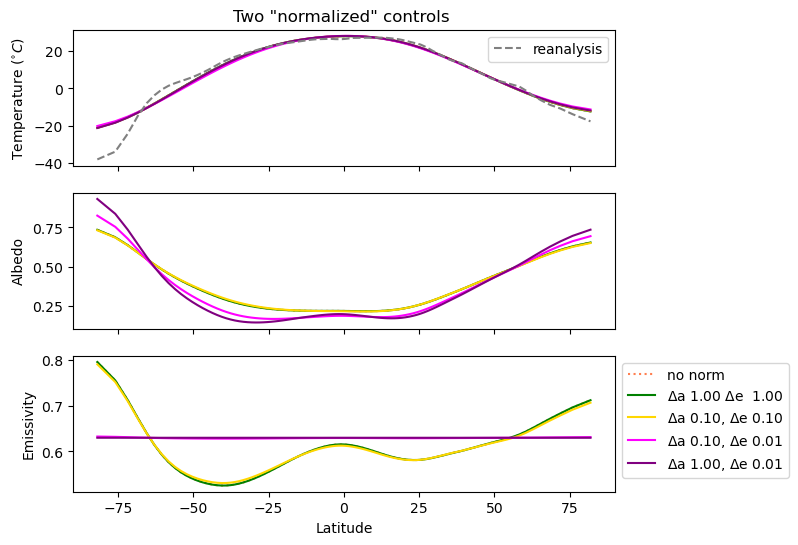

In [36]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(LAT, T2-273, ':', color='coral')
ax.plot(LAT, T_norm[0,:]-273, color='green')
ax.plot(LAT, T_norm[1,:]-273, color='gold')
ax.plot(LAT, T_norm[2,:]-273, color='magenta')
ax.plot(LAT, T_norm[3,:]-273, color='purple')

ax.plot(LAT,Ts_annual_interp,'--', label='reanalysis', color='0.5')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(LAT, alpha2, ':', color='coral')
ax2.plot(LAT, alpha_norm[0,:], color='green')
ax2.plot(LAT, alpha_norm[1,:], color='gold')
ax2.plot(LAT, alpha_norm[2,:], color='magenta')
ax2.plot(LAT, alpha_norm[3,:], color='purple')
ax2.set_ylabel('Albedo')

ax3.plot(LAT, emiss2,  ':', label='no norm', color='coral')
ax3.plot(LAT, emiss_norm[0,:], color='green', label=(r'$\Delta$a %1.2f $\Delta$e  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(LAT, emiss_norm[1,:],color='gold', label=r'$\Delta$a %1.2f, $\Delta$e %1.2f' %(unc_alpha[1],unc_emiss[1]))
ax3.plot(LAT, emiss_norm[2,:],color='magenta', label=r'$\Delta$a %1.2f, $\Delta$e %1.2f' %(unc_alpha[2],unc_emiss[2]))
ax3.plot(LAT, emiss_norm[3,:],color='purple', label=r'$\Delta$a %1.2f, $\Delta$e %1.2f' %(unc_alpha[3],unc_emiss[3]))

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1,1))

What if we allow uncertainty to vary with latitude. For example, we would expect albedo to vary more where we have regions of ice/snow that melt (higher uncertainies), vs regions where there never is ice/snow (lower uncertainties)? 


In [25]:
T_norm2 = jnp.zeros((N))
alpha_norm2 = jnp.zeros((N))
emiss_norm2 = jnp.zeros((N))

# Initialize normalized parameters
u = jnp.zeros(2 * N)
eta = 1
max_iter = 500

# Uncertainties for normalization
Demiss = 0.01
Dalpha1 = 0.1
Dalpha2 = 0.9
Dalpha_var = Dalpha2*jnp.ones(N)
Dalpha_var = Dalpha_var.at[10:-10].set(Dalpha1)

UNCER = jnp.concatenate([Dalpha_var, Demiss * jnp.ones(N)])

# Gradient of the normalized cost
grad_u = grad(lambda u: cost_norm(u, UNCER))

for i in range(max_iter):
    J_val = cost_norm(u, UNCER)
    g = grad_u(u)
    if J_val < 0.3:
        break
    u = u - eta * g
print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
     
# Recover optimal physical controls
XXS_opt = u * UNCER
J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
J_norm2 = J_n
T_norm2 = T_norm2.at[:].set(T_n)
alpha_norm2 = alpha_norm2.at[:].set(alpha_n)
emiss_norm2 = emiss_norm2.at[:].set(emiss_n)

Delta alpha = 1.00000 and Delta epsilon = 0.01000
Step 058: J = 0.299367, ||grad|| = 5.81e-02


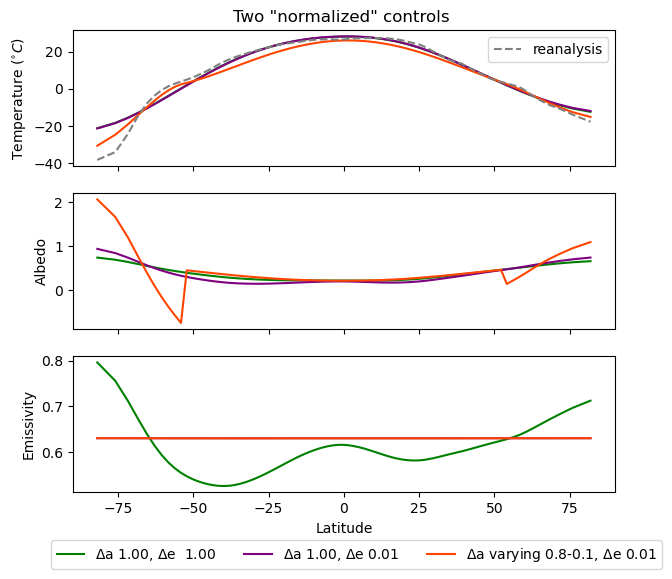

In [55]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(LAT, T_norm[0,:]-273, color='green')
ax.plot(LAT, T_norm[3,:]-273, color='purple')
ax.plot(LAT, T_norm2[:]-273, color='orangered')

ax.plot(LAT,Ts_annual_interp,'--', label='reanalysis', color='0.5')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(LAT, alpha_norm[0,:], color='green')
ax2.plot(LAT, alpha_norm[3,:], color='purple')
ax2.plot(LAT, alpha_norm2[:], color='orangered')
ax2.set_ylabel('Albedo')

ax3.plot(LAT, emiss_norm[0,:], color='green', label=(r'$\Delta$a %1.2f, $\Delta$e  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(LAT, emiss_norm[3,:], color='purple', label=r'$\Delta$a %1.2f, $\Delta$e %1.2f' %(unc_alpha[3],unc_emiss[3]))
ax3.plot(LAT, emiss_norm2[:], color='orangered', label=r'$\Delta$a varying 0.8-0.1, $\Delta$e %1.2f' %(unc_emiss[2]) )

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1.1,-0.3), ncol=3)